In [45]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Using VGG19 instead of VGG16
base_model = keras.applications.VGG19(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

In [46]:
# Freeze more layers - only unfreeze last few convolutional blocks
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

inputs = keras.Input(shape=(224, 224, 3))

In [47]:
# Add some preprocessing layers
x = keras.layers.experimental.preprocessing.RandomContrast(0.1)(inputs)
x = keras.layers.experimental.preprocessing.RandomZoom(0.1)(x)
x = base_model(x, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)

num_classes = 12
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_contrast_3 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               2626

In [48]:
# Enhanced data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [49]:
# Load datasets
train_it = train_datagen.flow_from_directory(
    'AUGLOKAL/train',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    subset='training',
    batch_size=32
)

valid_it = train_datagen.flow_from_directory(
    'AUGLOKAL/train',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    subset='validation',
    batch_size=32,
    shuffle=False
)

Found 2173 images belonging to 12 classes.
Found 536 images belonging to 12 classes.


In [50]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_it.classes),
    y=train_it.classes
)
class_weights = dict(enumerate(class_weights))

print("\nClass Weights:")
for i, w in enumerate(class_weights.values()):
    print(f"Kelas {i}: {w:.2f}x bobot")


Class Weights:
Kelas 0: 0.91x bobot
Kelas 1: 0.90x bobot
Kelas 2: 1.56x bobot
Kelas 3: 1.37x bobot
Kelas 4: 0.89x bobot
Kelas 5: 1.74x bobot
Kelas 6: 0.95x bobot
Kelas 7: 1.57x bobot
Kelas 8: 0.65x bobot
Kelas 9: 0.50x bobot
Kelas 10: 1.31x bobot
Kelas 11: 1.39x bobot


In [51]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7
)

In [ ]:
# Compile with lower learning rate
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
# Train with more epochs (early stopping will handle it)
history = model.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=int(train_it.samples/train_it.batch_size),
    validation_steps=int(valid_it.samples/valid_it.batch_size),
    epochs=50, 
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/50


67/67 [==============================] - 32s 424ms/step - loss: 7.6945 - accuracy: 0.1397 - val_loss: 7.4636 - val_accuracy: 0.0801 - lr: 1.0000e-05
Epoch 2/50
67/67 [==============================] - 27s 394ms/step - loss: 7.2145 - accuracy: 0.2289 - val_loss: 7.1128 - val_accuracy: 0.3770 - lr: 1.0000e-05
Epoch 3/50
67/67 [==============================] - 27s 393ms/step - loss: 6.7453 - accuracy: 0.3596 - val_loss: 6.6749 - val_accuracy: 0.6387 - lr: 1.0000e-05
Epoch 4/50
67/67 [==============================] - 26s 390ms/step - loss: 6.3349 - accuracy: 0.4741 - val_loss: 6.2251 - val_accuracy: 0.7246 - lr: 1.0000e-05
Epoch 5/50
67/67 [==============================] - 26s 390ms/step - loss: 6.0310 - accuracy: 0.5922 - val_loss: 5.9448 - val_accuracy: 0.7637 - lr: 1.0000e-05
Epoch 6/50
67/67 [==============================] - 26s 392ms/step - loss: 5.7390 - accuracy: 0.6997 - val_loss: 5.6388 - val_accuracy: 0.7949 - lr: 1.0000e-05
Epoch 7/50
67/67 [==============================] -

In [54]:
# Evaluation
loss, acc = model.evaluate(valid_it, steps=int(valid_it.samples/valid_it.batch_size))
print(f"Validation Loss: {loss:.4f}, Accuracy: {acc:.4f}")

16/16 [==============================] - 6s 330ms/step - loss: 3.2469 - accuracy: 0.9375
Validation Loss: 3.2469, Accuracy: 0.9375


In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Test evaluation
test_generator = train_datagen.flow_from_directory(
    'dataset/test',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

predictions = model.predict(test_generator)
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

print(confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))

Found 4029 images belonging to 12 classes.
126/126 [==============================] - 39s 306ms/step
[[203   2   7   0  34   0   0   0 145   4   0   0]
 [  0 374   0   0   0   1   0   0   3   3   0   0]
 [  6   7 358   0   3   0   3   0  10   1   0   0]
 [  0   0   0  63   0   0   0   1   0   0   0   0]
 [ 15   4   3   0 552   4  17   1   4   1   0   0]
 [  1  24   0   0  10 455  11  18   0   2   9   0]
 [  0   0  19   0  24   0 358   1   0   0   1   0]
 [  0   0   0   0   3   3   0  29   5   0   0   0]
 [ 33   7   2  10  15   3   3  11 120  20 145  22]
 [  0  42   1   1   4  16   3   6   5 279  34   9]
 [  4  12  46   9   3   8  15   7  32  38 192  34]
 [  0   0   0   0   0   0   0   0   0   0   4  32]]
              precision    recall  f1-score   support

           0       0.77      0.51      0.62       395
           1       0.79      0.98      0.88       381
           2       0.82      0.92      0.87       388
           3       0.76      0.98      0.86        64
           4   

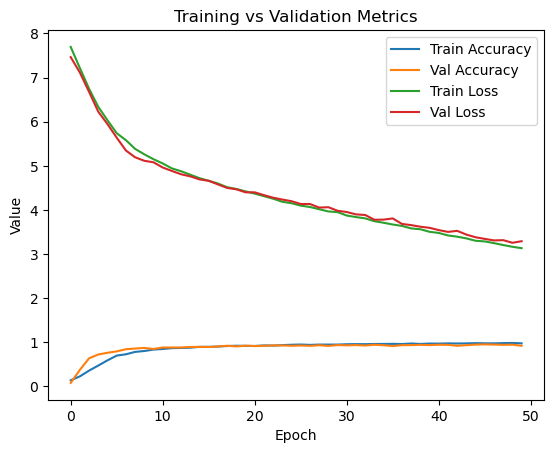

In [56]:
import matplotlib.pyplot as plt

# Misal variabel 'history' adalah hasil dari model.fit()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training vs Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()


In [57]:
model.save('cnnVGG19v4.h5')

In [58]:
import os
from collections import defaultdict
import hashlib

dataset_path = 'GOOGLEIMAGES/train'  # Ganti dengan path dataset Anda

def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Kumpulkan semua path gambar
all_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_files.append(os.path.join(root, file))

# Hitung hash
hashes = defaultdict(list)
for file in all_files:
    hashes[file_hash(file)].append(file)

# Tampilkan duplikat
for hash_val, files in hashes.items():
    if len(files) > 1:
        print(f"Duplikat ({len(files)} gambar):")
        for f in files:
            print(f"  - {f}")